In [1]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.preprocessing import StandardScaler


import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

import os
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 0. Util functions

In [2]:
INPUT_DIR = '/Users/G_bgyl/si699/Rushhour/raw_data/sf_speed_data/test_data_2016/'
DIR_ROOT = '/Users/G_bgyl/si699/Rushhour/'

In [3]:
# Specifiy directory containing shape file
GIS_DATA_DIR = '../../raw_data/census_zones/sf/'
SHP_FILE = 'geo_export_8c14e8b6-2d3c-4109-af6b-f6e25cb69f0c.shp'
SF_CENSUS_ZONES = gpd.GeoDataFrame.from_file(GIS_DATA_DIR + SHP_FILE)
print('Size of census zones df: {}'.format(SF_CENSUS_ZONES.shape))
SF_CENSUS_ZONES.head()

Size of census zones df: (197, 13)


aland10  awater10 countyfp10 funcstat10      geoid10   intptlat10  \
0  370459.0       0.0        075          S  06075016500  +37.7741958   
1  309097.0       0.0        075          S  06075016400  +37.7750995   
2  245867.0       0.0        075          S  06075016300  +37.7760456   
3  368901.0       0.0        075          S  06075016100  +37.7799831   
4  158236.0       0.0        075          S  06075016000  +37.7823363   

     intptlon10 mtfcc10 name10        namelsad10 statefp10 tractce10  \
0  -122.4477884   G5020    165  Census Tract 165        06    016500   
1  -122.4369729   G5020    164  Census Tract 164        06    016400   
2  -122.4295509   G5020    163  Census Tract 163        06    016300   
3  -122.4286631   G5020    161  Census Tract 161        06    016100   
4  -122.4224838   G5020    160  Census Tract 160        06    016000   

                                            geometry  
0  POLYGON ((-122.446471 37.775802, -122.44478 37...  
1  POLYGON ((-122.44034 37.77658, -122.439844 37....  
2  POLYGON ((-122.429152 37.778007, -122.428909 3...  
3  POLYGON ((-122.428909 37.778039, -122.429152 3...  
4  POLYGON ((-122.420425 37.780583, -122.420336 3...

In [4]:
def file_cleaner(data_intput, data_output, file_name):
    '''Reads in SF speed data and formats them into proper csv files'''
    
    with open(data_intput + file_name, 'r') as old_file:
        with open(data_output + file_name, 'w') as new_file:
            first = 0 
            for line in old_file.readlines():
                # If it is the first line, separate the header from the data
                if first == 0: 
                    line = re.sub(r'\t|\n|\s+', '', line)
                    header = re.findall(r'[A-Z+?\_?]+', line)
                    data = re.findall(r'[\-?\d+?\/?\.?\:?]+|\,(?=\,)', line)
                    
                    # Date and time are connected 
                    date = re.search(r'(\d{2}\/){2}\d{4}', data[1]).group(0)
                    time = re.search(r'(\d{2}\:){2}\d{2}', data[1]).group(0)
                    date = date + ' ' + time 
                    
                    # Remove the merged date and time
                    data.remove(data[1])
                    
                    # Insert separated date and time
                    data.insert(1, date)
                    
                    data = [x if x != ',' else '' for x in data]
                    header = (',').join(header)
                    data = (',').join(data)
                    new_file.write(header + '\n')
                    new_file.write(data + '\n')
                    first += 1 
                else:
                    if line != '\n':
                        line = line.rstrip()
                        new_file.write(line + '\n')

In [5]:
def mapping_function(traffic_df):
    """Convert pandas to geopandas, and return a df with information of region mapping id
    
    """
    # Convert pandas to geopandas
    geom = traffic_df.apply(lambda x: Point(x['LONGITUDE'], x['LATITUDE']), axis=1)
    traffic = gpd.GeoDataFrame(traffic_df, geometry=geom)
    # traffic.crs = {'init': 'epsg:4326'}
    print('Size of travel speed data: {}'.format(traffic.shape))


    # Join with census data
    # 'op' - operation | specify 'within' because we want our zip points 
    # that are within state polygons. 
    SF_CENSUS_ZONES.crs = traffic.crs
    mapped_traffic = gpd.sjoin(traffic, SF_CENSUS_ZONES, op='within')

    return mapped_traffic

In [6]:
def get_fname(path,contains=False):
    # get file name for all subfiles for the whole ukwac corpus.
    file = [f for f in os.listdir(path) if re.search('(.+\.csv$)', f)]
    if contains:
        file = [f for f in file if contains in f]
    file = sorted(file)
    return file

In [7]:
def convert_date(df, columns=['REPORT_TIME'],set_index = True):
    
    """ # input: 
        df: original dataframe. 
        columns: represent names of columns that was time type.
        change_index: True for audio and activity data, False for conversation data
        # output: dataframe. Turn timestamp from unix time into readable time. and set index and change time zone.
    """
    for col in columns:
#         df[col] = pd.to_datetime(df[col],unit='s',utc=True).dt.tz_convert('US/Eastern') # .dt.tz_localize('US/Eastern')
        df[col] = pd.to_datetime(df[col])
        print('begin change index in convert_date')
        if set_index:
            #there is only on timestamp column, so use it as index
            df.index =  df[col] # .dt.date

    return df

In [8]:
# tmp_df = pd.read_csv('../raw_data/sf_speed_data/test_data_2016/sfmtaAVLRawData01032016.csv')
# group_tmp_df = tmp_df.groupby('REV')

In [9]:
# tmp_df.columns

In [10]:
# i=0
# for region_id, group in group_tmp_df:
#     for raw_id, raw in group.iterrows():
#         print(','.join([str(cell) for cell in list(raw)]))
#         break

In [11]:
def generate_fname_wPath(DIR, region_id, attr =False):
    """Generate file name with whole path
    """
#     # avoid file name with "'"
#     if "'" in attr:
#         attr = attr.replace("'", "_")
    fname_wPath = '%s/%s_%s.csv'%(DIR,attr,region_id)
    return fname_wPath

    

In [12]:
def aggregate_to_region(input_path,output_path):
    """ this function take a directory of time series data and target output directory string as input, 
    get region-based csv file as a preparation for prediction function later.
    for now, this function is based on the output from 'def mapping_function()'
    only need to run once for data preparation.
    
    input: 
    input_path: a string of the path of input, contains one csv file for each day. 
                eg:'../output/sf_speed_data_clean/'
    output_path: a string of the path of output, will contains one csv file for each region
                eg:'../output/sf_speed_data_region/'
    
    output: 
    write files to output_path
    """
    out_file_attr = 'time_series_region'
    f_names = get_fname(input_path,contains = '2016')
    # make sure whether the output dir exists or not.
    if os.path.isdir(output_path):
        pass
    else:
        Print('Creating new directory...')
        command = 'mkdir {}'.format(output_path)
        os.system(command)
    
    for fname in f_names:
        day_file = pd.read_csv(input_path+fname)
        
        # loop though data for each region and open only one region file each time to save memory
        for region_id, group_df in day_file.groupby('geoid10'):# TODO: may need to change column name
            # make sure whether the region file has already exist
            out_fname = generate_fname_wPath(output_path, attr = out_file_attr,region_id = region_id)
            if os.path.exists(out_fname):
                f = open(out_fname,'a')
            else:
                f = open(out_fname,'w+')
                f.write(','.join(day_file.columns)+'\n')
                
            for _, rows in group_df.iterrows():
                f.write(','.join([str(cell) for cell in list(rows)])+'\n')
                
            f.close()
        print('finished %s'%(fname))
    

In [13]:
# from code snippet: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def predict_time_series_ARIMA(mean_series,title,fig_size,split_size = 0.9,full=False):
    labels = mean_series.index # add label
    
    X = mean_series.values
    size = int(len(X) * split_size)

    train, test = X[0:size], X[size:len(X)]
    
    test_label =labels[size:len(labels)]# add label
    
    history = [x for x in train]
    predictions = list()
    indexes = list()# add label
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        indexes .append(test_label[t])# add label
#         if t %100 ==0:
#             print('predicted=%f, expected=%f' % (yhat, obs))
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    print('Test RMSE: %.3f' % np.sqrt(mse))
    print('Test MAE: %.3f' % mae)
    
    # plot
    
    sns.set(rc={'figure.figsize':fig_size})
    if full:
        plt.plot(labels,X,label = 'train data')
#         plt.plot(labels[int(len(labels)/2):],X[int(len(X)/2):])
    else:
        plt.plot(indexes,test)
    plt.plot(indexes,predictions, color='red',label='validation data')#
    plt.legend()
    plt.title(title)
    
    return plt, mse

## 1. read in data

### 1.1 clean file format

In [56]:
# clean files

data_dir =DIR_ROOT + '/raw_data/sf_speed_data/test_data_2016/'
data_output = DIR_ROOT +'/output/sf_speed_data_clean/'
file_list = get_fname(data_dir,contains = '2016')
for fname in file_list:
    file_cleaner(data_dir,data_output,fname)

### 1.2 conduct mapping function

In [62]:
mapping_dir = data_output
map_fnames = get_fname(mapping_dir,contains = '2016')

for fname in map_fnames:
    traffic_df = pd.read_csv(mapping_dir+fname)
    df_mapped = mapping_function(traffic_df)
    df_mapped.to_csv(mapping_dir+fname, index = False)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Size of travel speed data: (494778, 10)
Size of travel speed data: (684534, 10)
Size of travel speed data: (306597, 10)
Size of travel speed data: (304830, 10)
Size of travel speed data: (308470, 10)
Size of travel speed data: (310483, 10)
Size of travel speed data: (266889, 10)


### 1.3 group data into regions

In [69]:
group_input_dir = mapping_dir
group_output_dir = DIR_ROOT+'/output/sfmta_regions/'
aggregate_to_region(group_input_dir,group_output_dir)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

In [14]:
def normalize(df,with_std=False):
    #fill na
    df = df.fillna(0)
    #scale data. output: ndarray
    scaler = StandardScaler(with_std = with_std)
    
    score_scale = scaler.fit_transform(df)
    # turn scaled data into df.
    df_scale = pd.DataFrame(score_scale,index=df.index, columns=df.columns)

    return df_scale

In [15]:
def region_by_time_generator(path, columns=['REPORT_TIME'],Y = 'SPEED',unit = 'H',with_std = False):
    """take a directory of user files into a frequency level time series.(mean)
    Actually it now returns a pandas series, which is the input of 'def predict_time_series_ARIMA function()'
    
    Inputs:
    path: the output file dir of 'def aggregate_to_region()'
    columns: the list column name string that need to convert to date
    Y: a string of one column that need to be treated as Y
    unit: time granularity. eg, 'H'
    aggregate_func: a function name, specifies how to aggragate data points.
    
    Output:
    new_time_df.iloc[0]: a pandas series with time as index, 
                         mean(or other aggregate_func()) speed within one hour(or other time granularity) as data.
    """
    print('begin create_time_df')
    f_names = get_fname(path)
    new_time_df = pd.DataFrame()
    for file_name in f_names:
        data_user = pd.read_csv(path+file_name,parse_dates=columns)
#         df_user = convert_date(data_user,columns=columns)
        data_user.index = data_user[columns[0]]
        df_user = data_user
        # select the column that is the Y 
        # col_inf = [i for i in df_user.columns if Y in i][0]
        col_inf = Y

        # group second data into one time unit.
        unitly_aggr = df_user[col_inf].resample(unit).mean()
        # unitly_aggr.plot(style = [':','--','-'])
        # turn a series of data into a row(with dataframe type).
        weekly_transposed = unitly_aggr.to_frame(name=re.sub("time_series_|\.csv", "", file_name))
        weekly_transposed = weekly_transposed.transpose()
        # add into final result
        new_time_df = pd.concat([new_time_df,weekly_transposed])
    print('finish create_time_df')
    new_time_df_new = normalize(new_time_df，with_std=False)

    return new_time_df_new

In [29]:
region_dir = DIR_ROOT+'/output/sfmta_regions/'
sample_time_series = region_by_time_generator(region_dir,columns=['REPORT_TIME'],Y = 'SPEED',unit = 'H')

begin create_time_df


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64

In [16]:
sample_time_series_scale.to_csv('../output/region_by_time_series_scale.csv', index = None)

NameError: name 'sample_time_series_scale' is not defined

In [19]:
sample_time_series_scale= pd.read_csv(DIR_ROOT +'/output/region_by_time_series_scale.csv')

In [17]:
sample_time_series= pd.read_csv(DIR_ROOT +'/output/region_by_time_series.csv')

In [18]:
sample_time_series.columns

Index(['2016-01-03 00:00:00', '2016-01-03 01:00:00', '2016-01-03 02:00:00',
       '2016-01-03 03:00:00', '2016-01-03 04:00:00', '2016-01-03 05:00:00',
       '2016-01-03 06:00:00', '2016-01-03 07:00:00', '2016-01-03 08:00:00',
       '2016-01-03 09:00:00',
       ...
       '2016-01-09 15:00:00', '2016-01-09 16:00:00', '2016-01-09 17:00:00',
       '2016-01-09 18:00:00', '2016-01-09 19:00:00', '2016-01-09 20:00:00',
       '2016-01-09 21:00:00', '2016-01-09 22:00:00', '2016-01-09 23:00:00',
       '2016-01-10 00:00:00'],
      dtype='object', length=169)

In [34]:
len(sample_time_series.mean())

169

In [35]:
#fill na
sample_time_series = sample_time_series.fillna(0)
#scale data. output: ndarray
score_scale = scaler.fit_transform(sample_time_series)
# turn scaled data into df.
sample_time_series_scale = pd.DataFrame(score_scale,index=sample_time_series.index, columns=sample_time_series.columns)
sample_time_series_scale.head()

REPORT_TIME        2016-01-03 00:00:00  2016-01-03 01:00:00  \
region_6075010100            -1.815261            -1.636400   
region_6075010200            -0.983154            -0.076146   
region_6075010300            -0.670705            -0.335590   
region_6075010400            -0.597119             0.531186   
region_6075010500            -0.824014            -0.433552   

REPORT_TIME        2016-01-03 02:00:00  2016-01-03 03:00:00  \
region_6075010100            -1.326053            -1.264963   
region_6075010200             0.069237            -0.143552   
region_6075010300             0.065720             1.010235   
region_6075010400            -0.268001             0.276582   
region_6075010500            -0.338861            -0.623397   

REPORT_TIME        2016-01-03 04:00:00  2016-01-03 05:00:00  \
region_6075010100            -1.390176            -1.730966   
region_6075010200            -0.105026            -0.535039   
region_6075010300             0.839405            -0.199916   
region_6075010400            -1.443385            -0.161660   
region_6075010500            -0.118337            -0.394042   

REPORT_TIME        2016-01-03 06:00:00  2016-01-03 07:00:00  \
region_6075010100            -1.973287            -1.730916   
region_6075010200            -1.379060            -1.397262   
region_6075010300            -0.537852            -0.458437   
region_6075010400            -0.599972            -0.626223   
region_6075010500            -0.845964            -0.855788   

REPORT_TIME        2016-01-03 08:00:00  2016-01-03 09:00:00  \
region_6075010100            -1.972368            -1.684837   
region_6075010200            -1.196396            -1.152431   
region_6075010300            -0.403222            -0.681748   
region_6075010400            -0.928945            -0.693902   
region_6075010500            -0.782182            -0.584299   

REPORT_TIME               ...           2016-01-09 15:00:00  \
region_6075010100         ...                     -1.689562   
region_6075010200         ...                     -1.466200   
region_6075010300         ...                     -0.406548   
region_6075010400         ...                     -0.054973   
region_6075010500         ...                     -0.653353   

REPORT_TIME        2016-01-09 16:00:00  2016-01-09 17:00:00  \
region_6075010100            -1.421288            -1.564544   
region_6075010200            -1.424699            -1.458012   
region_6075010300            -0.352991            -0.189338   
region_6075010400            -0.265122            -0.733263   
region_6075010500            -0.254027            -0.486115   

REPORT_TIME        2016-01-09 18:00:00  2016-01-09 19:00:00  \
region_6075010100            -1.613497            -1.866539   
region_6075010200            -1.453528            -1.488946   
region_6075010300            -0.529855            -0.218863   
region_6075010400            -0.119687            -0.279484   
region_6075010500            -0.481339            -0.229324   

REPORT_TIME        2016-01-09 20:00:00  2016-01-09 21:00:00  \
region_6075010100            -1.719114            -1.679501   
region_6075010200            -1.590973            -1.477496   
region_6075010300            -0.255096            -0.753948   
region_6075010400            -0.709813            -0.961121   
region_6075010500            -0.596491            -0.578630   

REPORT_TIME        2016-01-09 22:00:00  2016-01-09 23:00:00  \
region_6075010100            -1.837990            -1.808719   
region_6075010200            -1.905063            -1.374324   
region_6075010300            -0.406889            -0.308411   
region_6075010400            -0.241557            -0.153154   
region_6075010500            -0.935707            -0.782286   

REPORT_TIME        2016-01-10 00:00:00  
region_6075010100            -0.141036  
region_6075010200            -0.141036  
region_6075010300            -0.141036  
region_6075010400            -0.141036  
regio

In [22]:
# sample_time_series_scale.std()


In [44]:
sample_time_series_scale.index[8]

'region_6075010900'

### plot out ARIMA

No handles with labels found to put in legend.


Test MSE: 0.088


No handles with labels found to put in legend.


Test MSE: 0.131


No handles with labels found to put in legend.


Test MSE: 0.204


No handles with labels found to put in legend.


Test MSE: 0.461


No handles with labels found to put in legend.


Test MSE: 0.083


No handles with labels found to put in legend.


Test MSE: 0.276


No handles with labels found to put in legend.


Test MSE: 1.015


No handles with labels found to put in legend.


Test MSE: 0.133


No handles with labels found to put in legend.


Test MSE: 0.189


No handles with labels found to put in legend.


Test MSE: 0.289


No handles with labels found to put in legend.


Test MSE: 0.203


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.115


No handles with labels found to put in legend.


Test MSE: 0.083


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.749


No handles with labels found to put in legend.


Test MSE: 0.258


No handles with labels found to put in legend.


Test MSE: 1.636


No handles with labels found to put in legend.


Test MSE: 0.630


No handles with labels found to put in legend.


Test MSE: 0.251


No handles with labels found to put in legend.


Test MSE: 0.317


No handles with labels found to put in legend.


Test MSE: 0.185


No handles with labels found to put in legend.


Test MSE: 0.089


No handles with labels found to put in legend.


Test MSE: 0.081


No handles with labels found to put in legend.


Test MSE: 0.126


No handles with labels found to put in legend.


Test MSE: 0.354


No handles with labels found to put in legend.


Test MSE: 0.049


No handles with labels found to put in legend.


Test MSE: 0.078


No handles with labels found to put in legend.


Test MSE: 0.724


No handles with labels found to put in legend.


Test MSE: 0.549


No handles with labels found to put in legend.


Test MSE: 0.192


No handles with labels found to put in legend.


Test MSE: 0.687


No handles with labels found to put in legend.


Test MSE: 0.085


No handles with labels found to put in legend.


Test MSE: 0.210


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.100


No handles with labels found to put in legend.


Test MSE: 0.099


No handles with labels found to put in legend.


Test MSE: 0.318


No handles with labels found to put in legend.


Test MSE: 0.470


No handles with labels found to put in legend.


Test MSE: 0.157


No handles with labels found to put in legend.


Test MSE: 0.158


No handles with labels found to put in legend.


Test MSE: 0.333


No handles with labels found to put in legend.


Test MSE: 0.101


No handles with labels found to put in legend.


Test MSE: 0.163


No handles with labels found to put in legend.


Test MSE: 0.280


No handles with labels found to put in legend.


Test MSE: 0.285


No handles with labels found to put in legend.


Test MSE: 0.134


No handles with labels found to put in legend.


Test MSE: 0.110


No handles with labels found to put in legend.


Test MSE: 0.155


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.062


No handles with labels found to put in legend.


Test MSE: 0.099


No handles with labels found to put in legend.


Test MSE: 0.137


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.158


No handles with labels found to put in legend.


Test MSE: 0.176


No handles with labels found to put in legend.


Test MSE: 0.102


No handles with labels found to put in legend.


Test MSE: 0.260


No handles with labels found to put in legend.


Test MSE: 0.133


No handles with labels found to put in legend.


Test MSE: 0.171


No handles with labels found to put in legend.


Test MSE: 0.326


No handles with labels found to put in legend.


Test MSE: 0.118


No handles with labels found to put in legend.


Test MSE: 0.084


No handles with labels found to put in legend.


Test MSE: 0.193


No handles with labels found to put in legend.


Test MSE: 0.262


No handles with labels found to put in legend.


Test MSE: 0.196


No handles with labels found to put in legend.


Test MSE: 0.284


No handles with labels found to put in legend.


Test MSE: 0.259


No handles with labels found to put in legend.


Test MSE: 0.126


No handles with labels found to put in legend.


Test MSE: 0.042


No handles with labels found to put in legend.


Test MSE: 0.085


No handles with labels found to put in legend.


Test MSE: 2.091


No handles with labels found to put in legend.


Test MSE: 0.144


No handles with labels found to put in legend.


Test MSE: 2.429


No handles with labels found to put in legend.


Test MSE: 0.114


No handles with labels found to put in legend.


Test MSE: 0.070


No handles with labels found to put in legend.


Test MSE: 0.698


No handles with labels found to put in legend.


Test MSE: 0.139


No handles with labels found to put in legend.


Test MSE: 0.776


No handles with labels found to put in legend.


Test MSE: 0.318


No handles with labels found to put in legend.


Test MSE: 0.194


No handles with labels found to put in legend.


Test MSE: 0.163


No handles with labels found to put in legend.


Test MSE: 0.547


No handles with labels found to put in legend.


Test MSE: 0.044


No handles with labels found to put in legend.


Test MSE: 0.104


No handles with labels found to put in legend.


Test MSE: 0.657


No handles with labels found to put in legend.


Test MSE: 0.159


No handles with labels found to put in legend.


Test MSE: 0.116


No handles with labels found to put in legend.


Test MSE: 0.349


No handles with labels found to put in legend.


Test MSE: 0.090


No handles with labels found to put in legend.


Test MSE: 0.105


No handles with labels found to put in legend.


Test MSE: 0.190


No handles with labels found to put in legend.


Test MSE: 0.375


No handles with labels found to put in legend.


Test MSE: 0.166


No handles with labels found to put in legend.


Test MSE: 0.265


No handles with labels found to put in legend.


Test MSE: 0.864


No handles with labels found to put in legend.


Test MSE: 1.188


No handles with labels found to put in legend.


Test MSE: 0.121


No handles with labels found to put in legend.


Test MSE: 0.387


No handles with labels found to put in legend.


Test MSE: 0.533


No handles with labels found to put in legend.


Test MSE: 0.346


No handles with labels found to put in legend.


Test MSE: 0.532


No handles with labels found to put in legend.


Test MSE: 0.461


No handles with labels found to put in legend.


Test MSE: 0.624


No handles with labels found to put in legend.


Test MSE: 0.549


No handles with labels found to put in legend.


Test MSE: 0.313


No handles with labels found to put in legend.


Test MSE: 0.425


No handles with labels found to put in legend.


Test MSE: 0.205


No handles with labels found to put in legend.


Test MSE: 0.450


No handles with labels found to put in legend.


Test MSE: 0.226


No handles with labels found to put in legend.


Test MSE: 0.914


No handles with labels found to put in legend.


Test MSE: 0.142


No handles with labels found to put in legend.


Test MSE: 0.064


No handles with labels found to put in legend.


Test MSE: 0.077


No handles with labels found to put in legend.


Test MSE: 0.787


No handles with labels found to put in legend.


Test MSE: 0.544


No handles with labels found to put in legend.


Test MSE: 0.460


No handles with labels found to put in legend.


Test MSE: 0.483


No handles with labels found to put in legend.


Test MSE: 1.423


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.348


No handles with labels found to put in legend.


Test MSE: 0.243


No handles with labels found to put in legend.


Test MSE: 0.583


No handles with labels found to put in legend.


Test MSE: 0.109


No handles with labels found to put in legend.


Test MSE: 0.479


No handles with labels found to put in legend.


Test MSE: 0.473


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.718


No handles with labels found to put in legend.


Test MSE: 0.094


No handles with labels found to put in legend.


Test MSE: 0.662


No handles with labels found to put in legend.


Test MSE: 0.170


No handles with labels found to put in legend.


Test MSE: 0.397


No handles with labels found to put in legend.


Test MSE: 0.375


No handles with labels found to put in legend.


Test MSE: 0.123


No handles with labels found to put in legend.


Test MSE: 0.194


No handles with labels found to put in legend.


Test MSE: 0.064


No handles with labels found to put in legend.


Test MSE: 0.767


No handles with labels found to put in legend.


Test MSE: 0.082


No handles with labels found to put in legend.


Test MSE: 0.560


No handles with labels found to put in legend.


Test MSE: 0.129


No handles with labels found to put in legend.


Test MSE: 0.131


No handles with labels found to put in legend.


Test MSE: 0.282


No handles with labels found to put in legend.


Test MSE: 0.374


No handles with labels found to put in legend.


Test MSE: 0.143


No handles with labels found to put in legend.


Test MSE: 0.671


No handles with labels found to put in legend.


Test MSE: 0.161


No handles with labels found to put in legend.


Test MSE: 0.762


No handles with labels found to put in legend.


Test MSE: 0.074


No handles with labels found to put in legend.


Test MSE: 0.119


No handles with labels found to put in legend.


Test MSE: 0.256


No handles with labels found to put in legend.


Test MSE: 0.699


No handles with labels found to put in legend.


Test MSE: 0.117


No handles with labels found to put in legend.


Test MSE: 0.411


No handles with labels found to put in legend.


Test MSE: 0.413


No handles with labels found to put in legend.


Test MSE: 0.583


No handles with labels found to put in legend.


Test MSE: 0.443


No handles with labels found to put in legend.


Test MSE: 0.074


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.314


No handles with labels found to put in legend.


Test MSE: 0.137


No handles with labels found to put in legend.


Test MSE: 0.148


No handles with labels found to put in legend.


Test MSE: 0.405


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.379


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.734


No handles with labels found to put in legend.


Test MSE: 0.349


No handles with labels found to put in legend.


Test MSE: 0.450


No handles with labels found to put in legend.


Test MSE: 0.157


No handles with labels found to put in legend.


Test MSE: 1.418


No handles with labels found to put in legend.


Test MSE: 0.669


No handles with labels found to put in legend.


Test MSE: 0.161


No handles with labels found to put in legend.


Test MSE: 0.516


No handles with labels found to put in legend.


Test MSE: 1.819


No handles with labels found to put in legend.


Test MSE: 0.213


No handles with labels found to put in legend.


Test MSE: 0.214


No handles with labels found to put in legend.


Test MSE: 0.179


No handles with labels found to put in legend.


Test MSE: 0.110


No handles with labels found to put in legend.


Test MSE: 0.326


No handles with labels found to put in legend.


Test MSE: 0.324


No handles with labels found to put in legend.


Test MSE: 0.198


No handles with labels found to put in legend.


Test MSE: 0.753


No handles with labels found to put in legend.


Test MSE: 0.177


No handles with labels found to put in legend.


Test MSE: 0.139


No handles with labels found to put in legend.


Test MSE: 0.110


No handles with labels found to put in legend.


Test MSE: 0.159


No handles with labels found to put in legend.


Test MSE: 0.260


No handles with labels found to put in legend.


Test MSE: 0.298


No handles with labels found to put in legend.


Test MSE: 0.163


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.144


No handles with labels found to put in legend.


Test MSE: 0.122


No handles with labels found to put in legend.


Test MSE: 0.261


No handles with labels found to put in legend.


Test MSE: 1.203


No handles with labels found to put in legend.


Test MSE: 0.111


No handles with labels found to put in legend.


Test MSE: 0.076


No handles with labels found to put in legend.


Test MSE: 0.274


No handles with labels found to put in legend.


Test MSE: 0.160


No handles with labels found to put in legend.


Test MSE: 0.081


No handles with labels found to put in legend.


Test MSE: 0.583


No handles with labels found to put in legend.


Test MSE: 0.065


No handles with labels found to put in legend.


Test MSE: 0.246


No handles with labels found to put in legend.


Test MSE: 0.104


No handles with labels found to put in legend.


Test MSE: 0.639


No handles with labels found to put in legend.


Test MSE: 0.471


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
No handles with labels found to put in legend.


Test MSE: 0.130


No handles with labels found to put in legend.


Test MSE: 0.150
0.3441974931193019


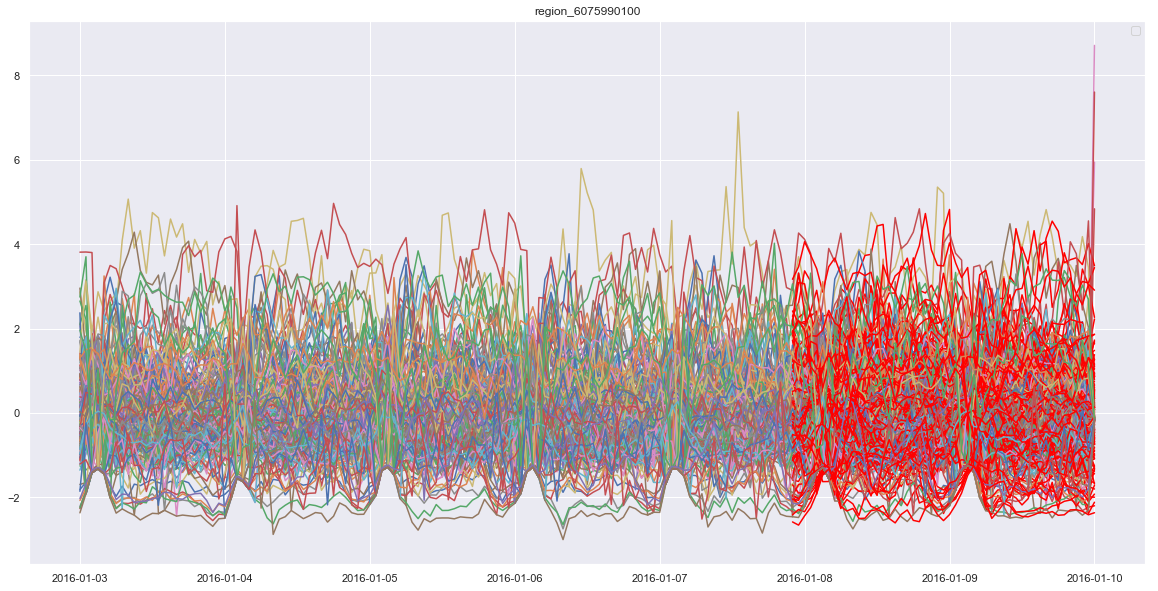

In [42]:
plt_list, mse_list = [], []
for region_id,row in sample_time_series_scale.iterrows():
    plt, mse = predict_time_series_ARIMA(row,title = region_id,fig_size = (20,10),split_size = 0.7,full = True)
    plt_list.append(plt)
    mse_list.append(mse)
print(np.mean(mse_list))
# for plt_ in plt_list:
#     plt.show()

## choose a busy area to analyze: region_6075010900

Test RMSE: 0.435
Test MAE: 0.330


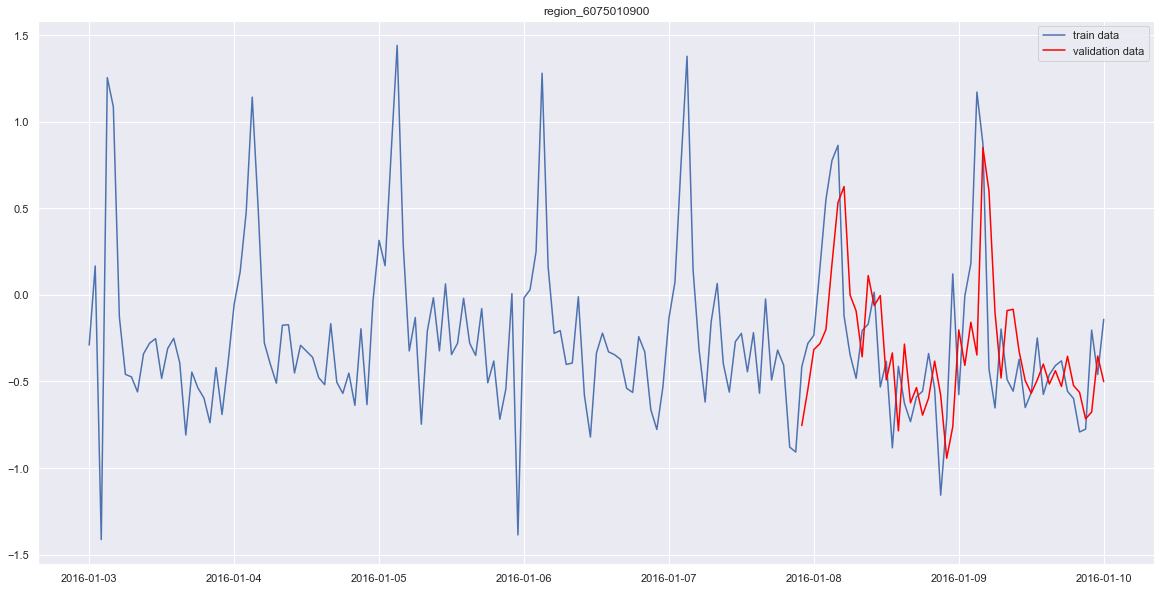

In [107]:
plt, mse = predict_time_series_ARIMA(sample_time_series_scale.iloc[8],title = sample_time_series_scale.index[8],fig_size = (20,10),split_size = 0.7,full = True)

No handles with labels found to put in legend.


Test MSE: 0.189


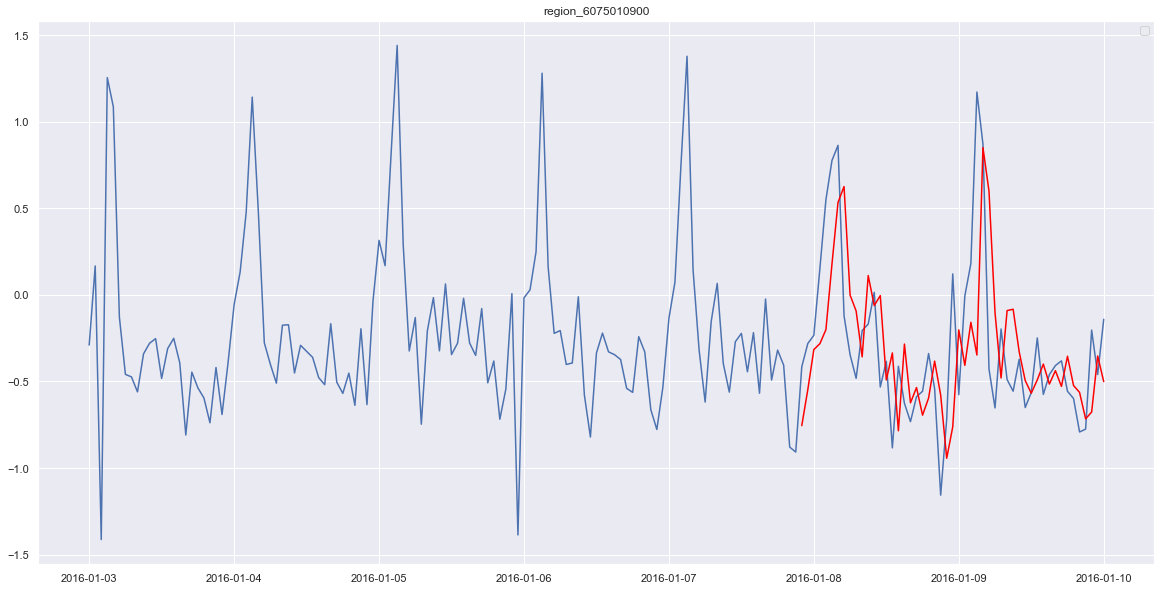

In [50]:
plt, mse = predict_time_series_ARIMA(sample_time_series_scale.iloc[8],title = sample_time_series_scale.index[8],fig_size = (20,10),split_size = 0.7,full = True)

In [59]:
new_data = sample_time_series_scale.iloc[8].T.to_frame()
len(new_data)

169

Epoch 1/10
 - 2s - loss: 0.2728
Epoch 2/10
 - 0s - loss: 0.2587
Epoch 3/10
 - 0s - loss: 0.2441
Epoch 4/10
 - 0s - loss: 0.2340
Epoch 5/10
 - 0s - loss: 0.2231
Epoch 6/10
 - 0s - loss: 0.2182
Epoch 7/10
 - 0s - loss: 0.2144
Epoch 8/10
 - 0s - loss: 0.2134
Epoch 9/10
 - 0s - loss: 0.2127
Epoch 10/10
 - 0s - loss: 0.2127
Test RMSE: 0.437
Test MAE: 0.328


Text(0.5,1,'region_6075010900 LSTM prediction')

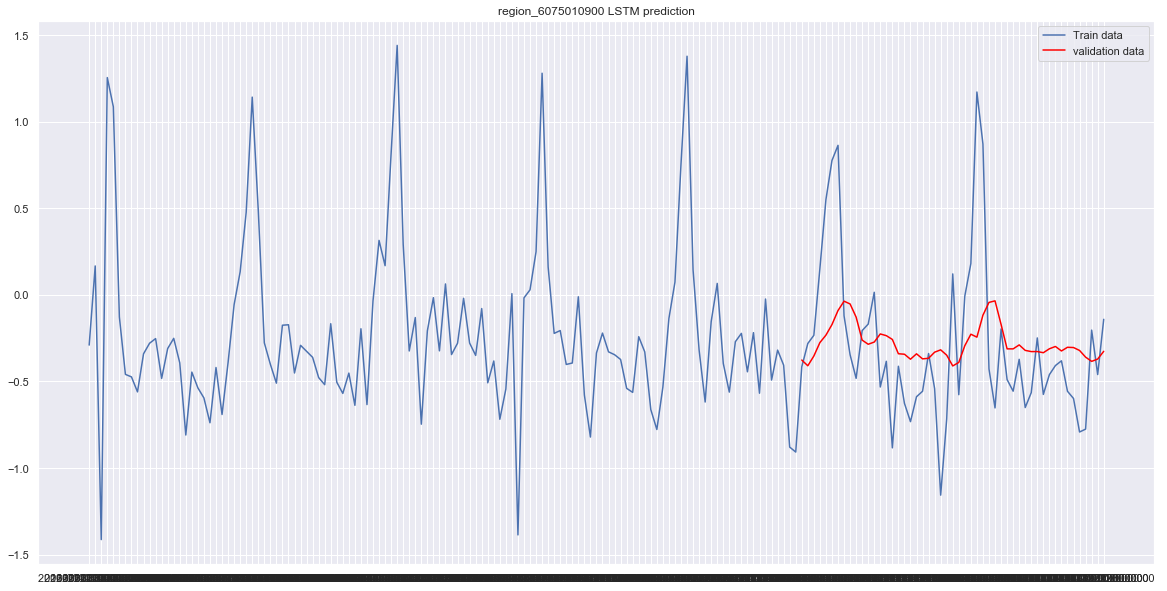

In [19]:
## code snippet: https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
split_size =0.7
time_window = 3
#creating dataframe
x_train, y_train = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
X_test, Y_test = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])

scaled_data = sample_time_series.iloc[8].T.to_frame()

labels = scaled_data.index # add label

#creating train and test sets
dataset = scaled_data.values

size = int(len(dataset) * split_size)

train, test = dataset[0:size], dataset[size:len(dataset)]

test_label =labels[size:len(labels)]# add label
#converting dataset into x_train and y_train

sub_x_train, sub_y_train = [], []
for i in range(time_window,len(train)):
    sub_x_train.append(train[i-time_window:i])
    sub_y_train.append(train[i])
sub_x_train, sub_y_train = np.array(sub_x_train), np.array(sub_y_train)
x_train = np.concatenate((x_train, sub_x_train), axis=0)
y_train = np.concatenate((y_train, sub_y_train), axis=0)

# create test dataset predicting values, using past time_window from the train data
inputs = dataset[len(dataset) - len(test) - time_window:]
inputs = inputs.reshape(-1,1)

sub_X_test = []
sub_Y_test = []
indexes = list()
for i in range(time_window,inputs.shape[0]):
    sub_X_test.append(inputs[i-time_window:i])
    sub_Y_test.append(inputs[i])
#     indexes.append(test_label[i])# add label
sub_X_test,sub_Y_test = np.array(sub_X_test), np.array(sub_Y_test)

X_test = np.concatenate((X_test, sub_X_test), axis=0)
Y_test = np.concatenate((Y_test, sub_Y_test), axis=0)





# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=16, verbose=2)


predict_speed = model.predict(X_test)
lstm_mse = mean_squared_error(Y_test, predict_speed)
lstm_mae = mean_absolute_error(Y_test, predict_speed)
print('Test RMSE: %.3f' % np.sqrt(lstm_mse))
print('Test MAE: %.3f' % lstm_mae)

# plot

sns.set(rc={'figure.figsize':(20,10)})

plt.plot(labels,dataset,label='Train data')
#         plt.plot(labels[int(len(labels)/2):],X[int(len(X)/2):])

plt.plot(test_label,predict_speed, color='red',label='validation data')#
plt.legend()
plt.title('region_6075010900 LSTM prediction')

In [110]:
## code snippet: https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
split_size =0.7
time_window = 3
#creating dataframe
x_train, y_train = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
X_test, Y_test = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
for i, row in sample_time_series_scale.iterrows():
    scaled_data = row.T.to_frame()

    labels = scaled_data.index # add label

    #creating train and test sets
    dataset = scaled_data.values

    size = int(len(dataset) * split_size)

    train, test = dataset[0:size], dataset[size:len(X)]

    test_label =labels[size:len(labels)]# add label
    #converting dataset into x_train and y_train

    sub_x_train, sub_y_train = [], []
    for i in range(time_window,len(train)):
        sub_x_train.append(train[i-time_window:i])
        sub_y_train.append(train[i])
    sub_x_train, sub_y_train = np.array(sub_x_train), np.array(sub_y_train)
    x_train = np.concatenate((x_train, sub_x_train), axis=0)
    y_train = np.concatenate((y_train, sub_y_train), axis=0)

    # create test dataset predicting values, using past time_window from the train data
    inputs = dataset[len(dataset) - len(test) - time_window:]
    inputs = inputs.reshape(-1,1)

    sub_X_test = []
    sub_Y_test = []
    indexes = list()
    for i in range(time_window,inputs.shape[0]):
        sub_X_test.append(inputs[i-time_window:i])
        sub_Y_test.append(inputs[i])
    #     indexes.append(test_label[i])# add label
    sub_X_test,sub_Y_test = np.array(sub_X_test), np.array(sub_Y_test)

    X_test = np.concatenate((X_test, sub_X_test), axis=0)
    Y_test = np.concatenate((Y_test, sub_Y_test), axis=0)





# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=16, verbose=2)


predict_speed = model.predict(X_test)
lstm_mse = mean_squared_error(Y_test, predict_speed)
lstm_mae = mean_absolute_error(Y_test, predict_speed)
print('Test RMSE: %.3f' % np.sqrt(lstm_mse))
print('Test MAE: %.3f' % lstm_mae)


Epoch 1/10
 - 16s - loss: 0.3491
Epoch 2/10
 - 11s - loss: 0.2977
Epoch 3/10
 - 10s - loss: 0.2962
Epoch 4/10
 - 10s - loss: 0.2951
Epoch 5/10
 - 10s - loss: 0.2954
Epoch 6/10
 - 12s - loss: 0.2952
Epoch 7/10
 - 10s - loss: 0.2950
Epoch 8/10
 - 10s - loss: 0.2952
Epoch 9/10
 - 10s - loss: 0.2950
Epoch 10/10
 - 10s - loss: 0.2943
Test RMSE: 0.590
Test MAE: 0.408


No handles with labels found to put in legend.


Test MSE: 0.620


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

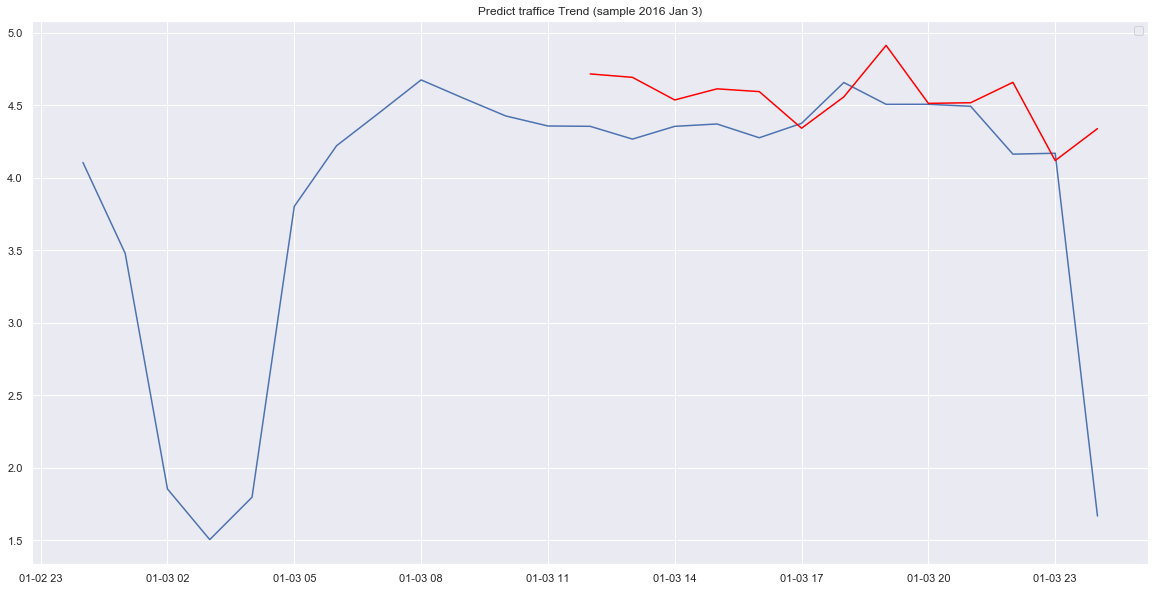

In [72]:
predict_time_series_ARIMA(sample_time_series.iloc[0],title = 'Predict traffice Trend (sample 2016 Jan 3)',fig_size = (20,10),split_size = 0.5,full = True)

In [32]:
pd.read_csv(data_output+fname).head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


REV          REPORT_TIME VEHICLE_TAG  LONGITUDE  LATITUDE  SPEED  HEADING  \
0  1506  01/03/2016 00:03:29           1 -122.42047  37.80633    0.0    201.0   
1  1506  01/03/2016 00:04:59           1 -122.42049  37.80638    0.0    256.0   
2  1506  01/03/2016 00:12:29           1 -122.42092  37.80690    0.0    247.0   
3  1506  01/03/2016 00:13:59           1 -122.42091  37.80690    0.0      0.0   
4  1506  01/03/2016 00:21:29           1 -122.42090  37.80691    0.0    259.0   

  TRAIN_ASSIGNMENT  PREDICTABLE  
0              NaN            0  
1              NaN            0  
2              NaN            0  
3              NaN            0  
4              NaN            0